In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import os
import sys
from scipy.ndimage import gaussian_filter1d
from scipy.signal import convolve
from brian2 import *

In [3]:
sys.path.append("../lib") # add code library to paths

# add lib to path 
from model_beta import Model



In [4]:
# TODO: turn this into  script

In [5]:
netname = 'recurrent_nn'
model = Model(netname)  # initiate the model


../output/recurrent_nn


In [6]:
params = {
'sig_c' : 0.05  ,    # bipolar receptive fied size ~ 1/5 of the actual size [mm]
'tau1' : 0.04   ,    # excitation time constant of the temporal filter [s]
'tau2' : 0.0876 ,    # rebound time constant [s]
'bifw' : 0.     ,    # relative weight of rebound/excitation [1]

'scale_mV' : 20.,     # UPDATED 

'tauA' : 0.15   ,     # time constant of amacrine cells [s]
'tauB' : 0.08   ,     # time constant of bipolar cells [s]
'tauG' : 0.01   ,     # time contant of ganglion cells [s]

'wAB' : 10.     ,     # synaptic weight from bipolar to amacrine [Hz]
'wBA' : -10.    ,     # synaptic weight from amacrine to bipolar [Hz]
'wGB' : 4.0     ,     # synaptic weight from bipolar to gangion  [Hz].   #UPDATED
'wGA' : 0.      ,     # synaptic weight from amacrine  to gangion  [Hz]

'slope' : 5     ,     # slope for ganglion cell recritifation [Hz/mV].   #UPDATED
'threshold' : 0 ,     # threshold for ganglion cell recritifation [Hz/mV]
'sig_pool' : 0.065 ,  # sigma for gaussian pooling in ganlion gells [mm]


'spacing' : 0.005  ,  # spacing of cells on the lattice [mm]
'dt' : 0.001      ,   # integration time step [s]
'N' : 512          ,  # number of neurons in each layer [1]


# idx = int(N/2)
# b =  0.160         # half bar width [mm]
# speed =  0.8       # speed [mm/s]  
}


In [7]:

# create connectivity matrix TODO write a class for this !!!

C = np.zeros((params['N'],params['N']))
ii = np.arange(0,params['N']-1,1).astype(int)  # list of source cells for rightward connections
ji = ii + 1                          # target cells of rightward connections


C[ii,ji] = 1

ii = np.arange(1,params['N'],1).astype(int)    # list of source cells for leftward connections
ji = ii - 1                         # target cells of leftward connections

C[ii,ji] = 1


In [8]:

model.set_params(params)
model.set_connectivity(C)


# simulate response to global step full contrast

In [35]:

dur = 3.                      # duration of the simulation [s]
tps = int(dur/params['dt'])             # number of time-points in the simulation [1]
time = np.arange(0,tps)*params['dt']    # time array for the simulation 1xtps, in [s]

start = int(1./params['dt'])
stop  = int(2./params['dt']) 

# initialize the stimulus
S = np.zeros((params['N'],tps))
S[:,start:stop] = 1


In [36]:
model.set_stimulus(S,'gStep')
model.simulate()

../output/recurrent_nn/gStep


# simulate response to global step  half contrast

In [37]:

dur = 3.                                # duration of the simulation [s]
tps = int(dur/params['dt'])             # number of time-points in the simulation [1]
time = np.arange(0,tps)*params['dt']    # time array for the simulation 1xtps, in [s]

start = int(1./params['dt'])
stop  = int(2./params['dt']) 

# initialize the stimulus
S = np.zeros((params['N'],tps))
S[:,start:stop] = .5


In [38]:
model.set_stimulus(S,'gStephalf')
model.simulate()

../output/recurrent_nn/gStephalf


In [42]:
# loop over contrasts 
contrasts = np.arange(0.1,1.1,0.1)
S = np.zeros((params['N'],tps))

for c in contrasts: 
    S[:,start:stop] = c
    stimname = f'gStep_{c}'
    model.set_stimulus(S,stimname)
    model.simulate()

../output/recurrent_nn/gStep_0.1
../output/recurrent_nn/gStep_0.2
../output/recurrent_nn/gStep_0.30000000000000004
../output/recurrent_nn/gStep_0.4
../output/recurrent_nn/gStep_0.5
../output/recurrent_nn/gStep_0.6000000000000001
../output/recurrent_nn/gStep_0.7000000000000001
../output/recurrent_nn/gStep_0.8
../output/recurrent_nn/gStep_0.9
../output/recurrent_nn/gStep_1.0


In [15]:
# loop over paramerter and save response, steady state
import pandas as pd
from joblib import Parallel,delayed


wBAs = np.arange(1,25,1)
tauAs = np.logspace(0,1)*0.02
wBAs = wBAs
tauAs = tauAs[::2]

print(len(wBAs),len(tauAs))
# wBAs = wBAs[:2]
# tauAs = tauAs[:2]

df = pd.DataFrame(columns = ['BC206', 'VB*','wBA','tauA'])
measure_point = int(2.9/params['dt'])



dur = 4.                                # duration of the simulation [s]
tps = int(dur/params['dt'])             # number of time-points in the simulation [1]
time = np.arange(0,tps)*params['dt']    # time array for the simulation 1xtps, in [s]

start = int(1./params['dt'])
stop  = int(3./params['dt']) 

# initialize the stimulus
S = np.zeros((params['N'],tps))
S[:,start:stop] = 1

model.set_stimulus(S,'gStep')
model.dt = 0.01

grid = np.array(np.meshgrid(wBAs,tauAs)).T.reshape(-1,2)

def run_one(par):


        wBA = par[0]
        tauA= par[1]
        params['tauA'] = tauA
        params['wBA'] = -1*wBA

        model.set_params(params)
        BC206 = model.simulate(save = False)
        VBstar = BC206[measure_point]
    

        dict = {'BC206': BC206,
                'wBA': wBA,
                'tauA': tauA,
                'VB*' : VBstar
                }
        
        return dict



X = Parallel(n_jobs = 8, verbose=10)(delayed(run_one)(g) for g in grid)


for xi in X:
        df.loc[len(df)] = xi

#save dataframe 
df.to_csv(f'{model.dir}/{model.stimname}/grid_steadystate.csv')


24 25
../output/recurrent_nn/gStep


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


40004000

4000
4000
4000
4000
4000
4000
4000


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   55.3s


4000
4000
4000
4000
4000
4000
4000


[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  1.8min


4000
4000
4000
4000
4000
4000
4000
4000


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  1.9min


KeyboardInterrupt: 

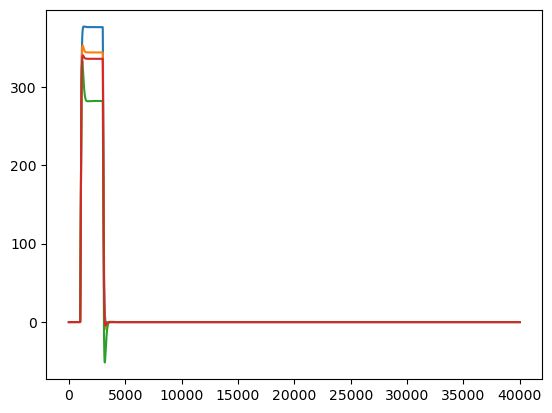

In [13]:
plt.plot(df['BC206'].values[0])
plt.plot(df['BC206'].values[1])
plt.plot(df['BC206'].values[2])
plt.plot(df['BC206'].values[3])